# Toxic Comment Classification by Hrithik

Importing Required Libraries

In [40]:
import pandas as pd
import numpy as np
import re
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score
from statistics import mean
from nltk.corpus import stopwords


%matplotlib inline

## Reading the Data

In [41]:
train = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip")
test = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip")
test_y = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip")


In [42]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [43]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

There are no NULL values so no imputation is required.

In [45]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [46]:
test_y.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [47]:
print('Dimension of Training Data : ',train.shape)
print('Dimension of Testing Data : ',test.shape)

Dimension of Training Data :  (159571, 8)
Dimension of Testing Data :  (153164, 2)


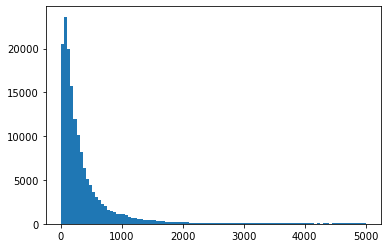

In [48]:
lens = train.comment_text.str.len()
plt.hist(lens, bins = 100)
plt.show()

From this graph we can conclude that most of the comments are less than 1000 words

In [49]:
labels = train[['toxic', 'severe_toxic',
                      'obscene', 'threat', 'insult', 'identity_hate']]
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

<AxesSubplot:ylabel='None'>

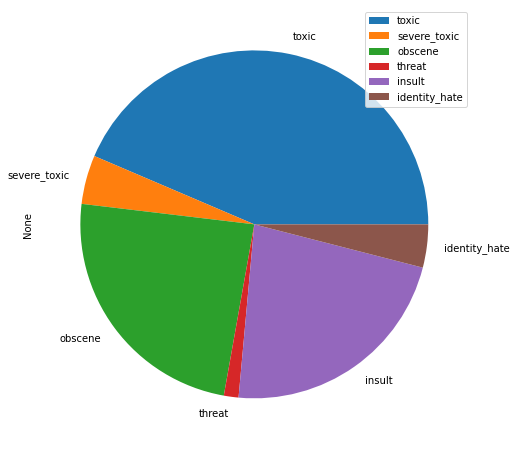

In [50]:
labels.sum().plot.pie(y= 'Comment count' , figsize =(8,8),legend = True)

Majority of comments are TOXIC

In [51]:
corr = labels.corr()
# corr.style.background_gradient(cmap = 'CMRmap').set_precision(2)
corr.style.background_gradient(cmap = 'jet').set_precision(2)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.00,0.31,0.68,0.16,0.65,0.27
severe_toxic,0.31,1.00,0.40,0.12,0.38,0.20
obscene,0.68,0.40,1.00,0.14,0.74,0.29
threat,0.16,0.12,0.14,1.00,0.15,0.12
insult,0.65,0.38,0.74,0.15,1.00,0.34
identity_hate,0.27,0.20,0.29,0.12,0.34,1.00


**This table gives the correlation between toxic-obscene, toxic-insult, obscene-insult**

## Vectorizing the Comments

In [52]:
vec = TfidfVectorizer(stop_words = 'english')

In [53]:
x = vec.fit_transform(train['comment_text'])
test_x= vec.transform(test['comment_text'])

In [54]:
prd = np.zeros((test.shape[0],len(label_cols)))

### Training the Multinomial Naive Bayes Model for all 6 labels

In [55]:
loss = []
for i,col in enumerate(label_cols):
    lr = MultinomialNB()
    print('Building model {} for column: {''}'.format(i+1,col)) 
    lr.fit(x,train[col])
    prd[:,i] = lr.predict_proba(test_x)[:,1]
    pred =  lr.predict(x)
    print('Column: {''}'.format(col))
    print('\nConfusion matrix\n',confusion_matrix(labels[col],pred))
    print(classification_report(labels[col],pred))
    print('ROC AUC:', roc_auc_score(train[col], pred))
    loss.append(roc_auc_score(train[col], pred))
    print('\n\n')
    

Building model 1 for column: toxic
Column: toxic

Confusion matrix
 [[144237     40]
 [ 11649   3645]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96    144277
           1       0.99      0.24      0.38     15294

    accuracy                           0.93    159571
   macro avg       0.96      0.62      0.67    159571
weighted avg       0.93      0.93      0.91    159571

ROC AUC: 0.6190257559539045



Building model 2 for column: severe_toxic
Column: severe_toxic

Confusion matrix
 [[157966     10]
 [  1595      0]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    157976
           1       0.00      0.00      0.00      1595

    accuracy                           0.99    159571
   macro avg       0.50      0.50      0.50    159571
weighted avg       0.98      0.99      0.99    159571

ROC AUC: 0.4999683496227275



Building model 3 for column: obscene
Column: obscene

Confusion 

In [56]:
print(np.mean(loss))

0.5400381612952728


**The Average ROC AUC score for MultinomialNB model is 0.54**

In [57]:
prd = np.zeros((test.shape[0],len(label_cols)))

In [58]:
l1 = []
for i,col in enumerate(label_cols):
    lr = LogisticRegression(C=2,random_state = i,class_weight = 'balanced',max_iter =100000)
    print('Building model {} for column: {''}'.format(i+1,col)) 
    lr.fit(x,train[col])
    #cvs.append(lr.score)
    prd[:,i] = lr.predict_proba(test_x)[:,1]
    pred =  lr.predict(x)
    print('Column: {''}'.format(col))
    print('\nConfusion matrix\n',confusion_matrix(labels[col],pred))
    print(classification_report(labels[col],pred))
    print('ROC AUC:', roc_auc_score(train[col], pred))
    l1.append(roc_auc_score(train[col], pred))
    print('\n\n')

Building model 1 for column: toxic
Column: toxic

Confusion matrix
 [[139352   4925]
 [   236  15058]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    144277
           1       0.75      0.98      0.85     15294

    accuracy                           0.97    159571
   macro avg       0.88      0.98      0.92    159571
weighted avg       0.97      0.97      0.97    159571

ROC AUC: 0.9752166935205777



Building model 2 for column: severe_toxic
Column: severe_toxic

Confusion matrix
 [[155288   2688]
 [     1   1594]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    157976
           1       0.37      1.00      0.54      1595

    accuracy                           0.98    159571
   macro avg       0.69      0.99      0.77    159571
weighted avg       0.99      0.98      0.99    159571

ROC AUC: 0.9911788989653284



Building model 3 for column: obscene
Column: obscene

Confusion 

In [59]:
print(np.mean(l1))

0.988831804604172


**The Average ROC AUC score for Logistic Regression model is 0.988**

So we will be using Logistic Regression Model for our final consideration for deployment

In [60]:
lr_toxic =  LogisticRegression(C=2,class_weight = 'balanced',max_iter =100000)
print('Building model 1 for Toxic')
lr_toxic.fit(x,train['toxic'])

Building model 1 for Toxic


LogisticRegression(C=2, class_weight='balanced', max_iter=100000)

In [61]:
lr_st =  LogisticRegression(C=2,class_weight = 'balanced',max_iter =100000)
print('Building model 2 for severe_toxic')
lr_st.fit(x,train['severe_toxic'])

Building model 2 for severe_toxic


LogisticRegression(C=2, class_weight='balanced', max_iter=100000)

In [62]:
lr_obs =  LogisticRegression(C=2,class_weight = 'balanced',max_iter =100000)
print('Building model 3 for obscene')
lr_obs.fit(x,train['obscene'])

Building model 3 for obscene


LogisticRegression(C=2, class_weight='balanced', max_iter=100000)

In [63]:
lr_threat =  LogisticRegression(C=2,class_weight = 'balanced',max_iter =100000)
print('Building model 4 for threat')
lr_threat.fit(x,train['threat'])

Building model 4 for threat


LogisticRegression(C=2, class_weight='balanced', max_iter=100000)

In [64]:
lr_insult =  LogisticRegression(C=2,class_weight = 'balanced',max_iter =100000)
print('Building model 5 for insult')
lr_insult.fit(x,train['insult'])

Building model 5 for insult


LogisticRegression(C=2, class_weight='balanced', max_iter=100000)

In [65]:
lr_ih =  LogisticRegression(C=2,class_weight = 'balanced',max_iter =100000)
print('Building model 6 for identity_hate')
lr_ih.fit(x,train['identity_hate'])

Building model 6 for identity_hate


LogisticRegression(C=2, class_weight='balanced', max_iter=100000)

### Prediction in code (for testing) 

In [ ]:
txt = 'Enter text in this place for prediction'
apl = vec.transform([txt])

In [31]:
x = lr_toxic.predict_proba(apl)
y = lr_st.predict_proba(apl)
z = lr_obs.predict_proba(apl)
a = lr_threat.predict_proba(apl)
b = lr_insult.predict_proba(apl)
c = lr_ih.predict_proba(apl)

In [ ]:
print(x[:,1],' ',y[:,1],' ',z[:,1],' ',a[:,1],' ',b[:,1],' ',c[:,1])

# Pickeling the code

Pickeling is done so that trained model can be saved for later use.

In [ ]:
pickle.dump(lr_toxic, open('m1.pkl','wb'))
pickle.dump(lr_st, open('m2.pkl','wb'))
pickle.dump(lr_obs, open('m3.pkl','wb'))
pickle.dump(lr_threat, open('m4.pkl','wb'))
pickle.dump(lr_insult, open('m5.pkl','wb'))
pickle.dump(lr_ih, open('m6.pkl','wb'))
pickle.dump(vec , open('vekt.pkl','wb'))